# Import libraries 

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
import statistics as stats

# Import data

In [121]:
data = pd.read_csv('../../raw_data/bitstampUSD.csv')

In [4]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831


# Nan's exploration

<AxesSubplot:>

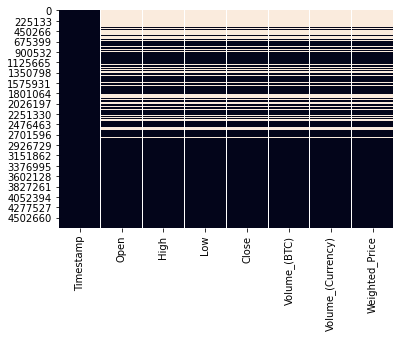

In [5]:
sns.heatmap(data.isnull(), cbar=False)

To be continued !

# Preprocessing, input data, Model, Cross Val

In [6]:
data = data[2798176:4727776].copy()

In [61]:
def select_data(data, data_start, data_end):
    
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', origin='unix')
    data = data[['Open', 'Timestamp']].set_index("Timestamp").fillna(method='ffill')
    
    if data_start != None:
        if data_end != None:
            data = data[data_start:data_end].copy()
    else:
        data = data.copy()
        
    return data

In [68]:
# select_data(data, "2020-8-1", "2020-10-2") 

In [ ]:
# select_data(data, "2020", "2020")

In [71]:
def preprocessing_data(data, shift_size, h):
    
    data_pp = data.copy()
    data_pp['diff_Open'] = data_pp['Open'].diff(h)
    data_pp['diff_Open'] = data_pp['diff_Open'].dropna()
    data_pp[f"t+{h}"] = data_pp['diff_Open'].shift(-h)
    
    for i in range(0, shift_size):
        data_pp[f't-{i}'] = data_pp['Open'].shift(i)
    data_shifted = data_pp.dropna()
    
    return data_shifted

In [26]:
def features_target(data_shifted, h):
    
    X = data_shifted.drop(columns=['Open', 'diff_Open', f"t+{h}"])
    y = data_shifted[f"t+{h}"].copy()
    y[y > 0] = 1
    y[y <= 0] = 0
    
    data_size = data_shifted.shape[0]
    
    return X, y, data_size

In [27]:
def input_data(X, y, data_size, sample_size, shift_size, train_size, test_size, h=1, w=0):    
 

    sample_X = X.iloc[data_size-(test_size * w + sample_size) : data_size - (test_size * w)]
    sample_y = y.iloc[data_size-(test_size * w + sample_size) : data_size - (test_size * w)]
    
    X_train = sample_X.iloc[0:train_size]
    y_train = sample_y.iloc[0:train_size]
    X_test = sample_X.iloc[(train_size+h-1):(sample_size-shift_size)]
    y_test = sample_y.iloc[(train_size+h-1):(sample_size-shift_size)]
    
    return X_train, X_test, y_train, y_test

In [28]:
def predict_score(model_init, X_train, X_test, y_train, y_test):
    model = model_init
    model = model.fit(X_train, y_train)
    results = model.predict(X_test)
    score = model.score(X_test, y_test) 
    return score

In [81]:
def cross_val(model_init, data, sample_size, shift_size, train_size, h=1, data_start=None, data_end=None):
    
    data = select_data(data, data_start, data_end)
    data_shifted = preprocessing_data(data, shift_size, h)
    X, y, data_size = features_target(data_shifted, h)
    test_size = sample_size - train_size
    
    r = round((data_size-train_size)/test_size)
    intervals = range(0, r-1)
    reversed_intervals = reversed(intervals)
    results = []
    
    for i in reversed_intervals:
        X_train, X_test, y_train, y_test = input_data(X, y, data_size, sample_size, shift_size, train_size, test_size, h, w=i)
        score = predict_score(model_init, X_train, X_test, y_train, y_test)
        results.append(score)
        
    return stats.mean(results), results
    

In [82]:
cross_val(RidgeClassifier(), data, 1000, 5, 700, h=2, data_start="2020", data_end="2020")

(0.5258904019011835,
 [0.5612244897959183,
  0.6190476190476191,
  0.5340136054421769,
  0.5816326530612245,
  0.6054421768707483,
  0.4421768707482993,
  0.5374149659863946,
  0.4965986394557823,
  0.5034013605442177,
  0.54421768707483,
  0.5578231292517006,
  0.5952380952380952,
  0.5748299319727891,
  0.5612244897959183,
  0.6326530612244898,
  0.5986394557823129,
  0.47278911564625853,
  0.6020408163265306,
  0.5714285714285714,
  0.5918367346938775,
  0.5918367346938775,
  0.5102040816326531,
  0.6258503401360545,
  0.6054421768707483,
  0.6496598639455783,
  0.45918367346938777,
  0.5102040816326531,
  0.5204081632653061,
  0.5034013605442177,
  0.47619047619047616,
  0.4897959183673469,
  0.5,
  0.5204081632653061,
  0.5068027210884354,
  0.4489795918367347,
  0.5,
  0.5170068027210885,
  0.5068027210884354,
  0.48299319727891155,
  0.5034013605442177,
  0.5272108843537415,
  0.47959183673469385,
  0.5136054421768708,
  0.5204081632653061,
  0.5374149659863946,
  0.510204081632

In [35]:
cross_val(RandomForestClassifier(), data, 1000, 5, 700, h=2)

(0.5116849352900283,
 [0.5340136054421769,
  0.46938775510204084,
  0.5306122448979592,
  0.5,
  0.5034013605442177,
  0.47959183673469385,
  0.564625850340136,
  0.6258503401360545,
  0.5170068027210885,
  0.5544217687074829,
  0.48639455782312924,
  0.5340136054421769,
  0.5340136054421769,
  0.5204081632653061,
  0.46258503401360546,
  0.5272108843537415,
  0.48639455782312924,
  0.48299319727891155,
  0.48299319727891155,
  0.43197278911564624,
  0.5034013605442177,
  0.5204081632653061,
  0.5,
  0.5340136054421769,
  0.5,
  0.5748299319727891,
  0.5238095238095238,
  0.4965986394557823,
  0.4489795918367347,
  0.6020408163265306,
  0.54421768707483,
  0.5136054421768708,
  0.5068027210884354,
  0.5374149659863946,
  0.4965986394557823,
  0.48299319727891155,
  0.5340136054421769,
  0.45918367346938777,
  0.5034013605442177,
  0.47278911564625853,
  0.5,
  0.4897959183673469,
  0.5238095238095238,
  0.4965986394557823,
  0.5578231292517006,
  0.5272108843537415,
  0.421768707482993